In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [31]:
# Load the BCCD dataset
dataset, info = tfds.load('bccd', with_info=True, as_supervised=False)

In [32]:
# The dataset is split into 'train' and 'test' by default
train_data = dataset['train']
val_data = dataset['test']

# Check the number of training and testing images
train_size = info.splits['train'].num_examples
val_size = info.splits['test'].num_examples

print(f'Training Images: {train_size}')
print(f'Validation Images: {val_size}')

Training Images: 205
Validation Images: 72


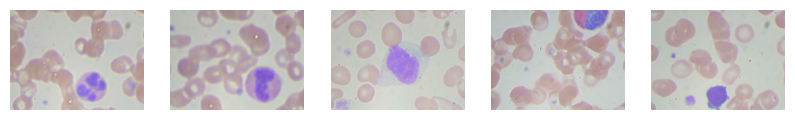

In [33]:
def plot_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, example in enumerate(dataset.take(num_images)):
        image = example['image']  # BCCD dataset returns a dictionary
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

plot_images(dataset['train'])


In [35]:
# Resize the images to (128, 128)
def resize_image(image, target_size=(128, 128)):
    return tf.image.resize(image, target_size)

# Image Augmentation function
def augment_image(image):
    image = resize_image(image)  # Resize image
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)     # Random vertical flip
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)  # Random contrast
    return image

# Apply augmentation on the training data
train_data = train_data.map(lambda x: augment_image(x['image']))
val_data = val_data.map(lambda x: (resize_image(x['image']))) # Keep test data unchanged


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# a. Load the dataset
# Assuming you have the BCCD dataset images organized in directories by class
# Dataset structure:
# BCCD/
# ├── train/
# │   ├── WBC/
# │   ├── RBC/
# │   └── Platelets/
# └── val/
#     ├── WBC/
#     ├── RBC/
#     └── Platelets/

dataset_dir = 'path_to_your_dataset/BCCD'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

# b. Show the number of training and testing images
num_train_images = sum([len(files) for r, d, files in os.walk(train_dir)])
num_val_images = sum([len(files) for r, d, files in os.walk(val_dir)])

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")

# c. Plot some images from the training dataset
def plot_images_from_directory(directory, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (root, _, files) in enumerate(os.walk(directory)):
        for j, file in enumerate(files):
            if j >= num_images:
                break
            img = plt.imread(os.path.join(root, file))
            ax = plt.subplot(3, 3, j + 1)
            plt.imshow(img)
            plt.title(root.split('/')[-1])
            plt.axis("off")
        if i >= 2:  # Limit to first 3 directories (classes)
            break

plot_images_from_directory(train_dir)

# d. Image augmentation – contrast, flipping, and rotation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,       # Rotation
    horizontal_flip=True,    # Horizontal flipping
    brightness_range=[0.8, 1.2]  # Contrast adjustment
)

val_datagen = ImageDataGenerator(rescale=1.0/255)  # Just rescaling for validation

# Loading augmented images from the directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# e. After augmentation, show the number of training and testing images
# The number of images remains the same in terms of actual dataset size but new augmented versions are generated on-the-fly
print(f"Number of augmented training images (on-the-fly): {num_train_images}")
print(f"Number of augmented validation images (on-the-fly): {num_val_images}")

# f. Normalizing the training data is already handled in the ImageDataGenerator with `rescale=1.0/255`

# g. Build a convolutional neural network for initial training without augmentation
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: WBC, RBC, Platelets
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN model (without augmentation)
history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

# h. Show the training and testing accuracy (without augmentation)
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy (No Augmentation)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (No Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy (No Augmentation)')
plt.show()

# i. Build a convolutional neural network to train images with augmentation
# We'll use the same model architecture but train with augmented images this time

augmented_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

# j. Show the training and testing accuracy (with augmentation)
plt.figure(figsize=(8, 5))
plt.plot(augmented_history.history['accuracy'], label='Training Accuracy (With Augmentation)')
plt.plot(augmented_history.history['val_accuracy'], label='Validation Accuracy (With Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy (With Augmentation)')
plt.show()

# k. Compare the training and testing accuracy before and after augmentation
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy (No Augmentation)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (No Augmentation)')
plt.plot(augmented_history.history['accuracy'], label='Training Accuracy (With Augmentation)')
plt.plot(augmented_history.history['val_accuracy'], label='Validation Accuracy (With Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Comparison of Training and Testing Accuracy')
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

# Load the BCCD dataset
data_dir = 'bccd_dataset'

# Get the list of image files
image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.jpg')]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_files, [0] * len(image_files), test_size=0.1, random_state=42)

print(f"Number of training images: {len(X_train)}")
print(f"Number of testing images: {len(X_test)}")

# Plot some sample images
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(plt.imread(X_train[i]))
    plt.axis('off')
plt.show()

# Perform image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    contrast_stretch_range=(0.8, 1.2)
)

# Fit and generate augmented training data
train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Get the updated number of training and testing images
X_train, y_train = next(train_generator)
print(f"Number of training images after augmentation: {len(X_train)}")
print(f"Number of testing images: {len(X_test)}")

# Normalize the training data
X_train = X_train / 255.0
X_test = np.array([plt.imread(f) for f in X_test]) / 255.0

# Build a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model without augmentation
history_no_aug = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Train the model with augmentation
history_with_aug = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Show the training and testing accuracy
print("Training and Testing Accuracy Without Augmentation:")
print(f"Training accuracy: {history_no_aug.history['accuracy'][-1]:.2f}")
print(f"Testing accuracy: {history_no_aug.history['val_accuracy'][-1]:.2f}")

print("\nTraining and Testing Accuracy With Augmentation:")
print(f"Training accuracy: {history_with_aug.history['accuracy'][-1]:.2f}")
print(f"Testing accuracy: {history_with_aug.history['val_accuracy'][-1]:.2f}")

# Compare the accuracy
print("\nComparison:")
print(f"Accuracy Improvement: {(history_with_aug.history['val_accuracy'][-1] - history_no_aug.history['val_accuracy'][-1]):.2f}")